In [1]:
from Data_Module import get_df_feats
df_feats, feat_cols = get_df_feats(refresh=False, persist=True)

[WARN] Could not save parquet; saving CSV instead.
 Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.


In [2]:
!pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

correlation analysis 

In [4]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the selected column
series = df_feats["season_end_year"].dropna()  # drop missing values just in case

result = adfuller(series)

# Display results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# Optional: add interpretation
if result[1] < 0.05:
    print("✅ The 'season_end_year' series is stationary.")
else:
    print("⚠️ The 'season_end_year' series is non-stationary — consider differencing or detrending.")


ADF Statistic: -5.1077
p-value: 0.0000
✅ The 'season_end_year' series is stationary.


In [5]:
safe_cols = [
    # per-90 & rates
    "g_per90","a_per90","ga_per90","pen_share","discipline_rate","gc_per90","clean_sheet_rate",
    # z-scores
    "ga_per90_z","g_per90_z","a_per90_z","gc_per90_z","clean_sheet_rate_z","discipline_rate_z",
    "pen_share_z","minutes_played_z","matches_played_z","goals_z","assists_z","penalty_goals_z",
    "own_goals_z","yellow_cards_z","second_yellow_cards_z","direct_red_cards_z",
    # weighted
    "ga_per90_w","g_per90_w","a_per90_w","gc_per90_w","clean_sheet_rate_w","discipline_rate_w","pen_share_w",
]

import numpy as np, pandas as pd
X = df_feats[safe_cols].replace([np.inf,-np.inf], np.nan).dropna()
corr = X.corr(method="pearson")
corr.round(2)


,g_per90,a_per90,ga_per90,pen_share,discipline_rate,gc_per90,clean_sheet_rate,ga_per90_z,g_per90_z,a_per90_z,...,yellow_cards_z,second_yellow_cards_z,direct_red_cards_z,ga_per90_w,g_per90_w,a_per90_w,gc_per90_w,clean_sheet_rate_w,discipline_rate_w,pen_share_w
g_per90,1.00,0.77,0.98,0.23,-0.00,-0.06,-0.07,0.92,0.93,0.72,...,0.08,-0.01,0.01,0.63,0.65,0.43,-0.00,-0.00,0.03,0.08
a_per90,0.77,1.00,0.87,0.24,0.01,-0.07,-0.09,0.83,0.74,0.94,...,0.12,0.01,0.01,0.56,0.45,0.69,0.00,0.00,0.04,0.10
ga_per90,0.98,0.87,1.00,0.24,-0.00,-0.06,-0.08,0.94,0.92,0.82,...,0.09,-0.00,0.01,0.64,0.63,0.52,0.00,0.00,0.03,0.09
pen_share,0.23,0.24,0.24,1.00,0.04,-0.04,-0.05,0.25,0.24,0.25,...,0.10,0.02,0.03,0.12,0.10,0.11,0.00,-0.00,0.04,0.83
discipline_rate,-0.00,0.01,-0.00,0.04,1.00,-0.10,-0.11,-0.00,-0.01,0.01,...,0.66,0.24,0.25,0.04,0.03,0.04,0.01,0.01,0.79,0.04
gc_per90,-0.06,-0.07,-0.06,-0.04,-0.10,1.00,0.30,-0.07,-0.06,-0.07,...,-0.12,-0.04,-0.04,0.00,-0.00,0.00,0.75,-0.05,0.01,0.00
clean_sheet_rate,-0.07,-0.09,-0.08,-0.05,-0.11,0.30,1.00,-0.09,-0.08,-0.09,...,-0.14,-0.05,-0.05,0.00,-0.00,0.00,-0.04,0.64,0.01,0.00
ga_per90_z,0.92,0.83,0.94,0.25,-0.00,-0.07,-0.09,1.00,0.98,0.85,...,0.10,-0.00,0.01,0.57,0.55,0.47,-0.00,-0.00,0.03,0.10
g_per90_z,0.93,0.74,0.92,0.24,-0.01,-0.06,-0.08,0.98,1.00,0.76,...,0.09,-0.00,0.01,0.56,0.57,0.39,-0.00,-0.00,0.02,0.09
a_per90_z,0.72,0.94,0.82,0.25,0.01,-0.07,-0.09,0.85,0.76,1.00,...,0.13,0.01,0.01,0.50,0.40,0.62,-0.00,0.00,0.03,0.10


In [6]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_by_player(df, col):
    out = {}
    for pid, grp in df.sort_values("season_end_year").groupby("player_id"):
        s = grp[col].dropna()
        if len(s) >= 8 and s.nunique() > 1:  # must have enough points and variation
            try:
                out[pid] = adfuller(s)[1]  # store p-value
            except Exception as e:
                pass  # skip problematic series
    return pd.Series(out, name=f"{col}_adf_p")

adf_p = adf_by_player(df_feats, "g_per90")
print(f"{(adf_p < 0.05).mean():.2%} of players have stationary g_per90 series.")



/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


39.09% of players have stationary g_per90 series.


In [7]:
from statsmodels.tsa.stattools import ccf
import numpy as np

def ccf_by_player(df, xcol, ycol, max_lag=5):
    rows = []
    for pid, g in df.sort_values("season_end_year").groupby("player_id"):
        x = g[xcol].dropna().values
        y = g[ycol].dropna().values
        n = min(len(x), len(y))
        if n >= 10:
            c = ccf(x[:n], y[:n])
            rows.append({"player_id": pid, "ccf_0": c[0], "ccf_1": c[1] if len(c)>1 else np.nan})
    return pd.DataFrame(rows)

cc = ccf_by_player(df_feats, "g_per90_z", "a_per90_z", max_lag=5)
cc.head(10)


,player_id,ccf_0,ccf_1
0,3333,0.752176,0.386954
1,7161,0.808164,0.473212
2,15799,0.780567,-0.148671
3,16136,0.924804,0.341927
4,16306,0.830703,0.042591
5,17259,0.830902,0.095082
6,18940,0.888427,0.513891
7,21327,0.296007,0.194142
8,27493,0.202283,0.021484
9,27807,0.924137,-0.420829


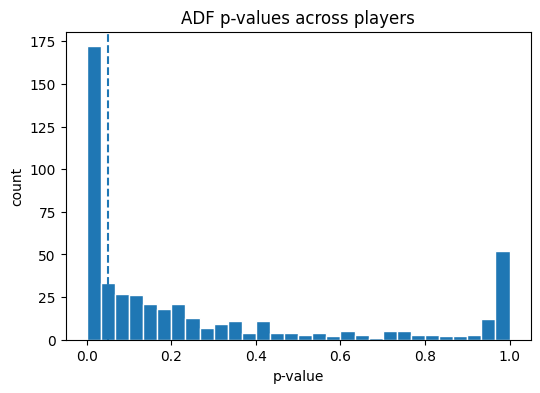

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# adf_p is the Series you built: index=player_id, values=p-values
pvals = adf_p.dropna().values

plt.figure(figsize=(6,4))
plt.hist(pvals, bins=30, edgecolor='white')
plt.axvline(0.05, linestyle='--')
plt.title("ADF p-values across players")
plt.xlabel("p-value")
plt.ylabel("count")
plt.show()


In [9]:
share = (adf_p < 0.05).mean()
print(f"{share:.1%} of players have a stationary series")


39.1% of players have a stationary series


/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:9

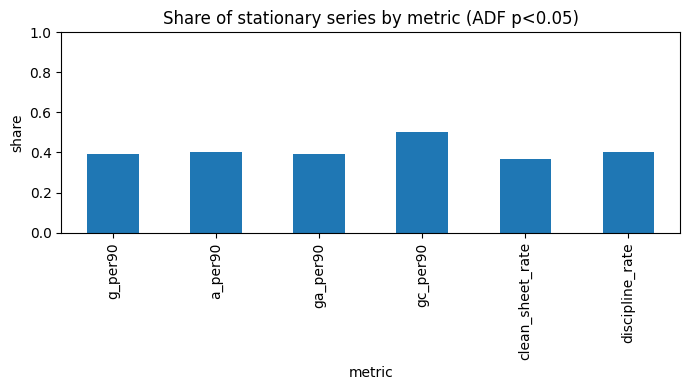

In [10]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stats = ["g_per90","a_per90","ga_per90","gc_per90","clean_sheet_rate","discipline_rate"]
rows = []

for col in stats:
    out = {}
    for pid, grp in df_feats.sort_values("season_end_year").groupby("player_id"):
        s = grp[col].dropna()
        if len(s) >= 8 and s.nunique() > 1:
            try:
                out[pid] = adfuller(s)[1]
            except:
                pass
    ser = pd.Series(out)
    rows.append({"metric": col, "share_stationary": (ser < 0.05).mean()})

table = pd.DataFrame(rows).set_index("metric")

# simple bar chart
plt.figure(figsize=(7,4))
table["share_stationary"].plot(kind="bar")
plt.ylim(0,1)
plt.title("Share of stationary series by metric (ADF p<0.05)")
plt.ylabel("share")
plt.xlabel("metric")
plt.tight_layout()
plt.show()


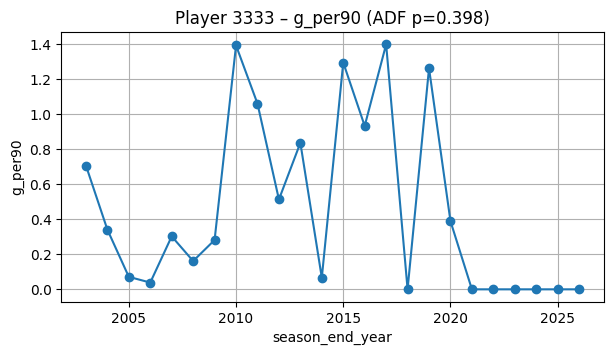

In [11]:
pid_example = df_feats["player_id"].mode().iloc[0]  # or pick one you care about
col = "g_per90"

g = (df_feats[df_feats["player_id"]==pid_example]
     .sort_values("season_end_year")[["season_end_year", col]].dropna())

from statsmodels.tsa.stattools import adfuller
p = adfuller(g[col])[1] if g[col].nunique()>1 and len(g)>=8 else np.nan

plt.figure(figsize=(7,3.5))
plt.plot(g["season_end_year"], g[col], marker='o')
plt.title(f"Player {pid_example} – {col} (ADF p={p:.3g})")
plt.xlabel("season_end_year")
plt.ylabel(col)
plt.grid(True)
plt.show()


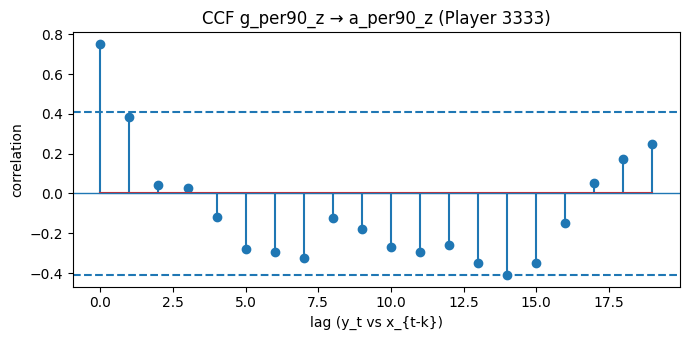

In [13]:
from statsmodels.tsa.stattools import ccf
import numpy as np
import matplotlib.pyplot as plt

pid = pid_example
xcol, ycol = "g_per90_z", "a_per90_z"

g = df_feats[df_feats["player_id"]==pid].sort_values("season_end_year")
x = g[xcol].dropna().values
y = g[ycol].dropna().values

# Optional: demean to be safe
x = x - x.mean()
y = y - y.mean()

n = min(len(x), len(y))
if n >= 10:
    cc = ccf(x[:n], y[:n])          # non-negative lags only
    L = min(20, len(cc))
    plt.figure(figsize=(7,3.5))
    plt.stem(range(L), cc[:L])      # <-- removed use_line_collection
    # ~95% conf. band (approx): ±2/sqrt(n)
    cb = 2/np.sqrt(n)
    plt.axhline( cb, linestyle="--")
    plt.axhline(-cb, linestyle="--")
    plt.axhline( 0, linewidth=1)
    plt.title(f"CCF {xcol} → {ycol} (Player {pid})")
    plt.xlabel("lag (y_t vs x_{t-k})")
    plt.ylabel("correlation")
    plt.tight_layout()
    plt.show()


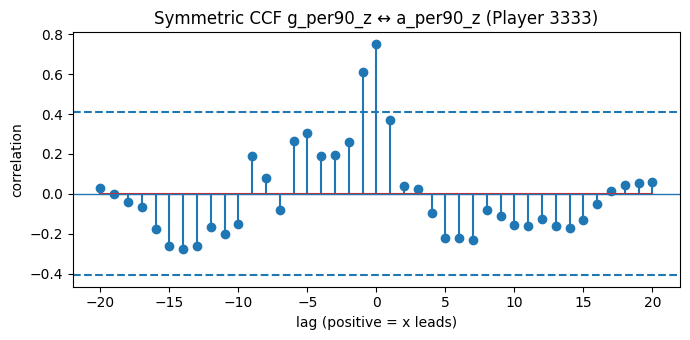

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def xcorr_sym(x, y):
    x = (x - x.mean()) / (x.std() or 1.0)
    y = (y - y.mean()) / (y.std() or 1.0)
    c = np.correlate(x, y, mode="full") / len(x)
    lags = np.arange(-len(x)+1, len(x))
    return lags, c

n = min(len(x), len(y))
if n >= 10:
    lags, cc = xcorr_sym(x[:n], y[:n])
    L = min(20, len(cc)//2)
    mid = len(cc)//2
    sel = slice(mid-L, mid+L+1)

    plt.figure(figsize=(7,3.5))
    plt.stem(lags[sel], cc[sel])
    cb = 2/np.sqrt(n)
    plt.axhline( cb, linestyle="--")
    plt.axhline(-cb, linestyle="--")
    plt.axhline( 0, linewidth=1)
    plt.title(f"Symmetric CCF {xcol} ↔ {ycol} (Player {pid})")
    plt.xlabel("lag (positive = x leads)")
    plt.ylabel("correlation")
    plt.tight_layout()
    plt.show()


In [ ]:
df_num = df_feats.select_dtypes(include=[np.number]).drop(
    columns=['player_id', 'team_id'], errors='ignore'
)
# make sure everything is float so pandas can build the covariance matrix
df_num = df_num.astype(float)
# compute covariance matrix
M = df_num.cov()
# eigenvalues and eigenvectors
from numpy import linalg as LA
w, v = LA.eig(M)
w  # eigenvalues

In [ ]:
pca = PCA()
pca.fit(df_num)


In [ ]:
pca.components_

In [ ]:
pca.explained_variance_

In [ ]:
pp = pca.transform(df_num)
def biplot(score,coeff,pcax,pcay,labels=None, Labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1/(xs.max()- xs.min())
    scaley = 1/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(len(xs)): # Iterate through the number of samples
        if Labels is None:
            pass # Placeholder for empty if block
        else:
            plt.text(xs[i]*scalex, ys[i]*scaley, Labels[i], color='blue', ha='center', va='center')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

In [ ]:
biplot(pp,pca.components_,1,2)
plt.show()

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X1 = min_max_scaler.fit_transform(df_num)

In [ ]:
pca = PCA()
X_pca=pca.fit(X1)

In [ ]:
pca.components_

In [ ]:
pca.explained_variance_

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# --- Visualize Explained variance ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PC')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()


In [ ]:
var_exp_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})
print(var_exp_df)

In [ ]:
features = df_num # solo las variables
labels = df_feats["player_id"]  # abreviaturas de los estados

# Escalar los datos
X_scaled = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obtener vectores de las variables originales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [ ]:
# Crear el biplot
plt.figure(figsize=(10, 7))

# 1. Puntos (proyecciones de los estados)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# 2. Etiquetas (abreviaturas de los estados)
for i, txt in enumerate(labels):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt, fontsize=9, color='blue', ha='center', va='center')

# 3. Flechas de las variables originales
for i, var in enumerate(features.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='brown', alpha=0.7, head_width=0.02)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, var, color='green', ha='center', va='center', fontsize=10)

# 4. Ejes y título
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Biplot between leagues")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()


 Linear model selection and regularization: LASSO Regression, a shrinkage method


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(df_num, df_num, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

In [ ]:
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

In [ ]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

In [ ]:
# Lasso Coefficient
lasso.coef_

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

np.random.seed(30) #we fix the seed so we can reproduce the data any time

# Perform grid search with cross-validation
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv.fit(X_train, y_train)

# Print best parameter values and score
print("Best Parameters:", lasso_cv.best_params_)
print("Best Score:", lasso_cv.best_score_)

In [ ]:
#Let's extract the best value of alpha
lasso_cv.best_params_.get('alpha')

In [ ]:
#And re-evaluate the Lasso regression model with this alpha
lasso = Lasso(alpha=lasso_cv.best_params_.get('alpha'))
lasso.fit(X_train, y_train)
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

In [ ]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

In [ ]:
# Lasso Coefficient
lasso.coef_

factor analysis


In [ ]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler

# Keep only numeric cols and drop IDs
X = (df_feats.select_dtypes(include=[np.number])
         .drop(columns=['player_id','team_id'], errors='ignore')
         .replace([np.inf, -np.inf], np.nan)
         .dropna(axis=0))

# Drop constant columns (variance = 0)
X = X.loc[:, X.nunique(dropna=True) > 1]

# Standardize (recommended)
Xz = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi2, p = calculate_bartlett_sphericity(Xz)   # want p < 0.05
kmo_per_var, kmo_model = calculate_kmo(Xz)    # >0.6 OK, >0.7 good, >0.8 great
print(f"Bartlett p={p:.3e}, KMO={kmo_model:.3f}")
